# Using PyMC for parameter estimation 
_______________
## Estimate parameters of ODE using Bayesian Inference on a smaller model 

### Motivation
I wanted to test whether I could code in **PyMC** and not have to use **R** to achieve the same result; i.e do parameter estimation using *Bayesian Inference*

To test the 

In [1]:
import pymc as pm
import numpy as np
from scipy.integrate import odeint

timedata=np.genfromtxt("data/timedata.txt", delimiter=',')
glc_concentration=np.genfromtxt("data/GLCexconc.txt", delimiter=',')
 
kcat_prob = pm.Uniform('kcat', 0.01, 1.0)
vmaxf_prob = pm.Uniform('vmaxf', 0.01, 1.0)

 
tspan = timedata
initialBiomass=0.043 #gDwt/l
initialGLCexconc=21 #mM
initialGLCinconc=0
initialG6pconc=0.801
initialG6Pproconc=0.801
rho=564 #gdw/Lcell
metabolite0 = [initialGLCexconc, initialGLCinconc, initialBiomass] #Initial conditions

 
# deterministic compartmental model
@pm.deterministic
def PK(kcat=kcat_prob, vmaxf=vmaxf_prob,tspan=tspan):
    def pk_model(metabolite, t):
        [GLCex,GLCin,Biomass]=metabolite
        
        #all constants in the model
        km=10.2e-3
        rho=564; #gDW/Lcell
        #24e-6*180*3600; #mM/h
        vmaxHKr=24e-6*1.16*3600 #mM/h
        KmATP=1
        KmG6P=47e-3
        KiATP=1
        KiGLC=47e-3
        KiG6P=47e-3
        KiADP=1
        ATP=1.54 #mM
        ADP=560e-3 #mM 
        G6P=0.801
        
        #Reactions in the model
        D=1+ ATP/KiATP+ G6P/KiG6P+ GLCin/KiGLC+ ADP/KiADP+ ATP*GLCin/(KmATP*KiGLC)+ADP*G6P/(KiADP*KmG6P)
        VHK=(vmaxf*10000*ATP*GLCin/(KmATP*KiGLC)-vmaxHKr*ADP*G6P/(KiADP*KmG6P))/D
        VGalP=kcat*10000*GLCex/(km+GLCex)

        mu=(VHK/rho-0.4531)/10.971
        if mu<=0:
            mu=0
        
        dglcex_dt=-VGalP*Biomass/rho #d(GLCex)/dt
        dglcin_dt=VGalP-VHK-mu*GLCin #d(GLCin)/dt
        dx_dt=mu*Biomass #d(biomass)/dt
        dmetabolite=[dglcex_dt,dglcin_dt,dx_dt]
        return dmetabolite
    soln = odeint(pk_model, metabolite0, tspan)
    GLCconc= soln[:,0]
    return [GLCconc]
#GLCconc = pm.Lambda('GLCconc', lambda PK=PK: PK[kcat_prob,vmaxf_prob])

 
prec = pm.Gamma('precision', alpha=0.1, beta=0.1)
 
# data likelihood
observed_glc = pm.Normal('observed_glc', mu=PK,tau=1000,value=glc_concentration, observed=True)


In [2]:
model = pm.Model([kcat_prob,vmaxf_prob,PK,prec,observed_glc])
 
# fit the model with mcmc
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(10000, 8000, 20)

 [-----------------100%-----------------] 10000 of 10000 complete in 289.1 sec

In [3]:
kcat_samples=mcmc.trace('kcat')[:]
vmaxf_samples=mcmc.trace('vmaxf')[:]

In [13]:
print('mean of kcat values:',round(kcat_samples.mean(),4),'\n')
print('mean of vmaxf values:',round(vmaxf_samples.mean(),4))


mean of kcat values: 0.2241 

mean of vmaxf values: 0.3555


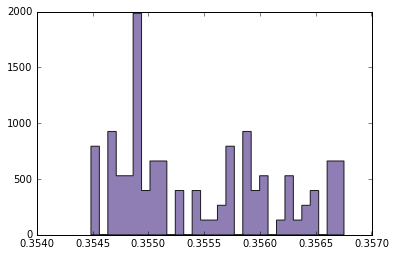

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(vmaxf_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $kcat$", color="#7A68A6", normed=True);

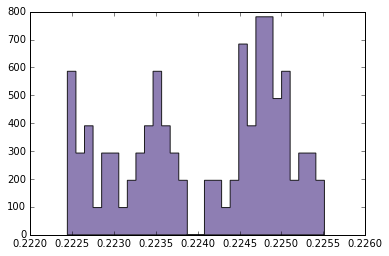

In [6]:
plt.hist(kcat_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $kcat$", color="#7A68A6", normed=True);